# (Kaggle) 房價預測
***
- 以下用房價預測資料, 觀察降低資料偏態的影響
- 觀察 標籤編碼、獨熱編碼、均值編碼, 在特徵數量 / 梯度提升樹、線性迴歸分數，時間上, 分別有什麼影響
- 展示特徵篩選的作法
  - 相關係數過濾法
  - L1 嵌入法的寫作方式

In [266]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy, time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df_train = pd.read_csv(data_path + 'house_train.csv')
df_test = pd.read_csv(data_path + 'house_test.csv')

# 預測的目標 房價
train_Y = np.log1p(df_train['SalePrice'])

df_train = df_train.drop(['Id','SalePrice'], axis = 1)
df_test = df_test.drop(['Id'], axis = 1)
df = pd.concat([df_train,df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [267]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
    if dtype == 'object':
        object_features.append(feature)
print(f' Numeric Features : {len(num_features)}\n')
print(f' Object Features : {len(object_features)}')

 Numeric Features : 36

 Object Features : 43


In [268]:
# 削減文字型欄位, 只剩數值型欄位
df_num_features = df[num_features]
df_num_features = df_num_features.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df_num_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [269]:
# 只留類別型欄位
df_object_features = df[object_features]
df_object_features = df_object_features.fillna('None')
train_num = train_Y.shape[0]
df_object_features.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


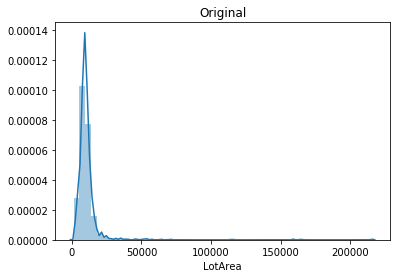

預測分數為 : 0.8464738883495573


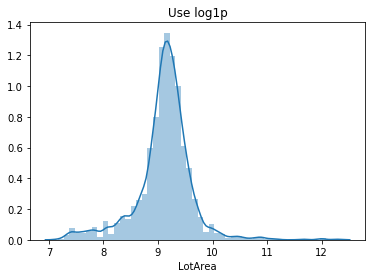

預測分數為 : 0.852911262961794


In [270]:
# 計算基礎分數 顯示 LotArea 的散佈圖
sns.distplot(df_num_features['LotArea'][:train_num])
plt.title('Original')
plt.show()
df_mm = MinMaxScaler().fit_transform(df_num_features)
train_X = df_mm[:train_num]
estimator = LinearRegression()
print("預測分數為 : " + str(cross_val_score(estimator, train_X, train_Y, cv=5).mean()))

## ==================================================================================== ##

# 將 LotArea 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df_num_features)
df_fixed['LotArea'] = np.log1p(df_fixed['LotArea'])
sns.distplot(df_fixed['LotArea'][:train_num])
plt.title('Use log1p')
plt.show()
df_fixed = MinMaxScaler().fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print("預測分數為 : " + str(cross_val_score(estimator, train_X, train_Y, cv=5).mean()))

In [271]:
# 針對類別型欄位

# 標籤編碼 + 線性迴歸
df_temp = pd.DataFrame()
for c in df_object_features.columns:
    df_temp[c] = LabelEncoder().fit_transform(df_object_features[c])
train_X = df_temp[:train_num]
estimator = LinearRegression()
start = time.time()
print("[ =========== 標籤編碼 + 線性迴歸 =========== ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec\n')

# 獨熱編碼 + 線性迴歸
df_temp = pd.get_dummies(df_object_features)
train_X = df_temp[:train_num]
estimator = LinearRegression()
start = time.time()
print("[ =========== 獨熱編碼 + 線性迴歸 =========== ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec\n')

# 均值編碼 + 線性迴歸
data = pd.concat([df_object_features[:train_num], train_Y], axis=1)
for c in df_object_features.columns:
    mean_df = data.groupby([c])['SalePrice'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    data = pd.merge(data, mean_df, on=c, how='left')
    data = data.drop([c] , axis=1)
data = data.drop(['SalePrice'] , axis=1)
estimator = LinearRegression()
start = time.time()
print("[ =========== 均值編碼 + 線性迴歸 =========== ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, data, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec\n')

# 標籤編碼 + 梯度提升樹
df_temp = pd.DataFrame()
for c in df_object_features.columns:
    df_temp[c] = LabelEncoder().fit_transform(df_object_features[c])
train_X = df_temp[:train_num]
estimator = GradientBoostingRegressor()
start = time.time()
print("[ =========== 標籤編碼 + 梯度提升樹 =========== ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec\n')

# 獨熱編碼 + 梯度提升樹
df_temp = pd.get_dummies(df_object_features)
train_X = df_temp[:train_num]
estimator = GradientBoostingRegressor()
start = time.time()
print("[ =========== 獨熱編碼 + 梯度提升樹 =========== ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec\n')

# 均值編碼 + 梯度提升樹
data = pd.concat([df_object_features[:train_num], train_Y], axis=1)
for c in df_object_features.columns:
    mean_df = data.groupby([c])['SalePrice'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    data = pd.merge(data, mean_df, on=c, how='left')
    data = data.drop([c] , axis=1)
data = data.drop(['SalePrice'] , axis=1)
estimator = GradientBoostingRegressor()
start = time.time()
print("[ =========== 均值編碼 + 梯度提升樹 =========== ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, data, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec')

[ =========== 標籤編碼 + 線性迴歸 =========== ]
shape : (1460, 43)
score : 0.6615606866851301
time : 0.022940874099731445 sec

[ =========== 獨熱編碼 + 線性迴歸 =========== ]
shape : (1460, 274)
score : -8.091816952374093e+22
time : 0.12125897407531738 sec

[ =========== 均值編碼 + 線性迴歸 =========== ]
shape : (1460, 274)
score : 0.7624230403716955
time : 0.03288602828979492 sec

[ =========== 標籤編碼 + 梯度提升樹 =========== ]
shape : (1460, 43)
score : 0.7775038044976882
time : 0.7587590217590332 sec

[ =========== 獨熱編碼 + 梯度提升樹 =========== ]
shape : (1460, 274)
score : 0.7914893999866164
time : 2.3470325469970703 sec

[ =========== 均值編碼 + 梯度提升樹 =========== ]
shape : (1460, 274)
score : 0.8056605863662126
time : 0.6393718719482422 sec
